# Welcome to the MS music notebook!

Import all the necessary libraries

In [12]:
# version used for the paper
import numpy as np # 1.23.1
import matplotlib.pyplot as plt # 3.6.3
import pandas as pd # 1.1.5
from matchms.importing import load_from_mzml # 0.17.0
import wavio # 0.0.7
from tqdm import tqdm # no version specified
from IPython.display import Audio # 7.30.1
import librosa # 0.10.0.post2

Define the path to the data and some other parameters, for now we can process MS1 and MS2 data.

In [3]:
upload_path = "" # path to the mzML file
file_name = ".mzML" # name of the mzML file
FS = 44100 # frame rate of the audio file
MINUTES = 17 # minutes of run in the mzML file to be used
OVERLAP_PC = 0.05 # "percentage" of overlap between consecutive spectra
MS2 = False # True if MS2 spectra are to be used, False if MS1 spectra are to be used

This step will preprocess the data and collect the information about the scans

In [4]:
uploaded_file = upload_path + file_name

if MS2:
    spectra_ms1 = list(load_from_mzml(uploaded_file, ms_level = 1, metadata_harmonization = False))
    spectra_ms2 = list(load_from_mzml(uploaded_file, ms_level = 2, metadata_harmonization = False))
    spectra = [[] for i in range(len(spectra_ms1) + len(spectra_ms2))]
    scan_numbers = [int(spectrum.metadata['title'].split('NativeID:\"scan=')[-1][:-1]) for spectrum in spectra_ms1 + spectra_ms2]
    sorted_scan_numbers = sorted(scan_numbers)
    scan_number_to_index = {scan_number: index for index, scan_number in enumerate(sorted_scan_numbers)}
    for spectrum in spectra_ms1 + spectra_ms2:
        scan_number = int(spectrum.metadata['title'].split('NativeID:\"scan=')[-1][:-1])
        spectra[scan_number_to_index[scan_number]] = spectrum
else:
    spectra = list(load_from_mzml(uploaded_file, ms_level = 1, metadata_harmonization = False))

processed_spectra = []
max_val = 0

for spectrum in spectra:
    peaks = pd.DataFrame({'mz':spectrum.peaks.mz, 'intensities':spectrum.peaks.intensities})
    peaks['rounded_mzs'] = peaks['mz'].round()
    grouped_peaks = peaks.groupby('rounded_mzs').sum()
    max_val = max(max_val, grouped_peaks['intensities'].max())
    processed_spectra.append(grouped_peaks)

smallest_mz = min([spec.index[0] for spec in processed_spectra])
largest_mz = max([spec.index[-1] for spec in processed_spectra])
mzs = [float(i) for i in list(range(int(smallest_mz), int(largest_mz) + 1))]

seconds_per_minute = 60
total_seconds = round(MINUTES * seconds_per_minute)
samples_per_scan = round(FS * total_seconds / len(processed_spectra))
song = None
song_cutoff_val = None

if (samples_per_scan * len(processed_spectra)) - (FS * total_seconds) < 0:
    song_cutoff_val = (samples_per_scan * len(processed_spectra)) - (FS * total_seconds)

t = np.linspace(0, total_seconds, total_seconds * FS, True)

massive_df = []
for mz in mzs:
    mz_intensities = []
    for spectrum in processed_spectra:
        if mz in spectrum.index:
            intensity = spectrum.loc[mz, 'intensities']
            mz_intensities.append(intensity)
        else:
            mz_intensities.append(0)
    massive_df.append(mz_intensities)
massive_df = pd.DataFrame(massive_df, index = mzs)
massive_df = massive_df / max_val

In [10]:
def _set_gradient(
        row_of_intensities, new_note_to_process, ind, percent, samples_per_scan, OVERLAP_PC,
        grad_start,
        grad_end
        ):
    start = ind * samples_per_scan
    end = start + samples_per_scan
    start_internal = 0
    end_internal = samples_per_scan
    new_note = np.zeros(len(new_note_to_process[start:end]))
    # define overlap
    if OVERLAP_PC == 0:
        l_overlap = 0
        grad_start = False
        grad_end = False
    else:
        l_overlap = round(OVERLAP_PC * (end_internal - start_internal))
    if grad_end:
        end_gradient = np.linspace(percent, row_of_intensities[ind+1], l_overlap * 2)[:l_overlap]
    if grad_start:
        start_gradient = np.linspace(row_of_intensities[ind-1], percent, l_overlap * 2)[l_overlap:]
    if not grad_start and not grad_end:
        new_note[start_internal:end_internal] = new_note_to_process[start:end] * percent
    elif grad_start and grad_end:
        new_note[start_internal:start_internal+l_overlap] = new_note_to_process[start:start+l_overlap] * start_gradient
        new_note[end_internal-l_overlap:end_internal] = new_note_to_process[end-l_overlap:end] * end_gradient
        new_note[start_internal+l_overlap:end_internal-l_overlap] = new_note_to_process[start+l_overlap:end-l_overlap] * percent
    elif grad_start and not grad_end:
        new_note[start_internal:start_internal+l_overlap] = new_note_to_process[start:start+l_overlap] * start_gradient
        new_note[start_internal+l_overlap:end_internal] = new_note_to_process[start+l_overlap:end] * percent
    elif grad_end and not grad_start:
        new_note[end_internal-l_overlap:end_internal] = new_note_to_process[end-l_overlap:end] * end_gradient
        new_note[start_internal:end_internal-l_overlap] = new_note_to_process[start:end-l_overlap] * percent
    
    return new_note

In [11]:
def add_gradient(row_of_intensities, new_note_imported, samples_per_scan, OVERLAP_PC):
    new_note_temp = new_note_imported.copy()
    note_parts = []
    for ind, percent in row_of_intensities.items():
        if ind == 0:
            temp = _set_gradient(
                row_of_intensities, new_note_temp, ind, percent, samples_per_scan, OVERLAP_PC,
                grad_start=False,
                grad_end=True,
                )
            note_parts.append(temp)
        elif ind == len(row_of_intensities) - 1:
            temp = _set_gradient(
                row_of_intensities, new_note_temp, ind, percent, samples_per_scan, OVERLAP_PC,
                grad_start=True,
                grad_end=False,
                )
            note_parts.append(temp)
        else:
            temp = _set_gradient(
                row_of_intensities, new_note_temp, ind, percent, samples_per_scan, OVERLAP_PC,
                grad_start=True,
                grad_end=True,
                )
            note_parts.append(temp)
    return np.concatenate(note_parts)

In [12]:
# first note, just to initialize the song
pbar = tqdm(total=len(massive_df))
for mz, row in massive_df.iloc[:1].iterrows():
    new_note = np.sin(mz * t * 2 * np.pi)
    new_note_temp = add_gradient(row, new_note, samples_per_scan, OVERLAP_PC)
    song = new_note_temp
    pbar.update(1)

# rest of the notes
for mz, row in massive_df.iloc[1:].iterrows():
    new_note = np.sin(mz * t * 2 * np.pi)
    new_note_temp = add_gradient(row, new_note, samples_per_scan, OVERLAP_PC)
    song += new_note_temp
    pbar.update(1)

if song_cutoff_val:
    song = song[:song_cutoff_val]

pbar.close()

  0%|          | 0/902 [00:00<?, ?it/s]

100%|██████████| 902/902 [00:13<00:00, 67.83it/s]


In [187]:
D = librosa.stft(song)
D_harmonic16, D_percussive16 = librosa.decompose.hpss(D, margin=16)
y_harmonic = librosa.istft(D_harmonic16, length=len(song))
song = y_harmonic

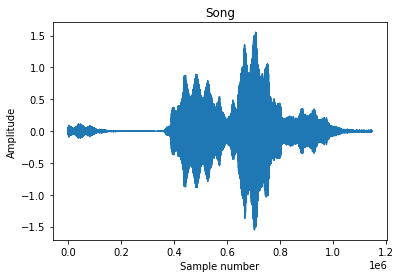

In [188]:
plt.plot(np.linspace(0, len(song), len(song)), song)
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.title('Song')
plt.show()

In [16]:
# normalize
audio = song * (2**15 - 1) / np.max(np.abs(song))
audio = audio.astype(np.int16)

In [17]:
output_path = "" # path to save the audio
wavio.write(output_path + file_name.split(".mzML")[0] + ".wav", audio, FS, sampwidth=2) # save the audio

In [106]:
Audio(data=song, rate=FS)